In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune
import tempfile
from ray import train
from pathlib import Path
import os
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
from tqdm import tqdm
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_dir = os.path.abspath("./data")

train_set = datasets.MNIST(
    root=data_dir, train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.MNIST(
    root=data_dir, train=False, transform=transforms.ToTensor(), download=True)

test_abs = int(len(train_set) * 0.8)
train_set, val_set = random_split(train_set, [test_abs, len(train_set) - test_abs])

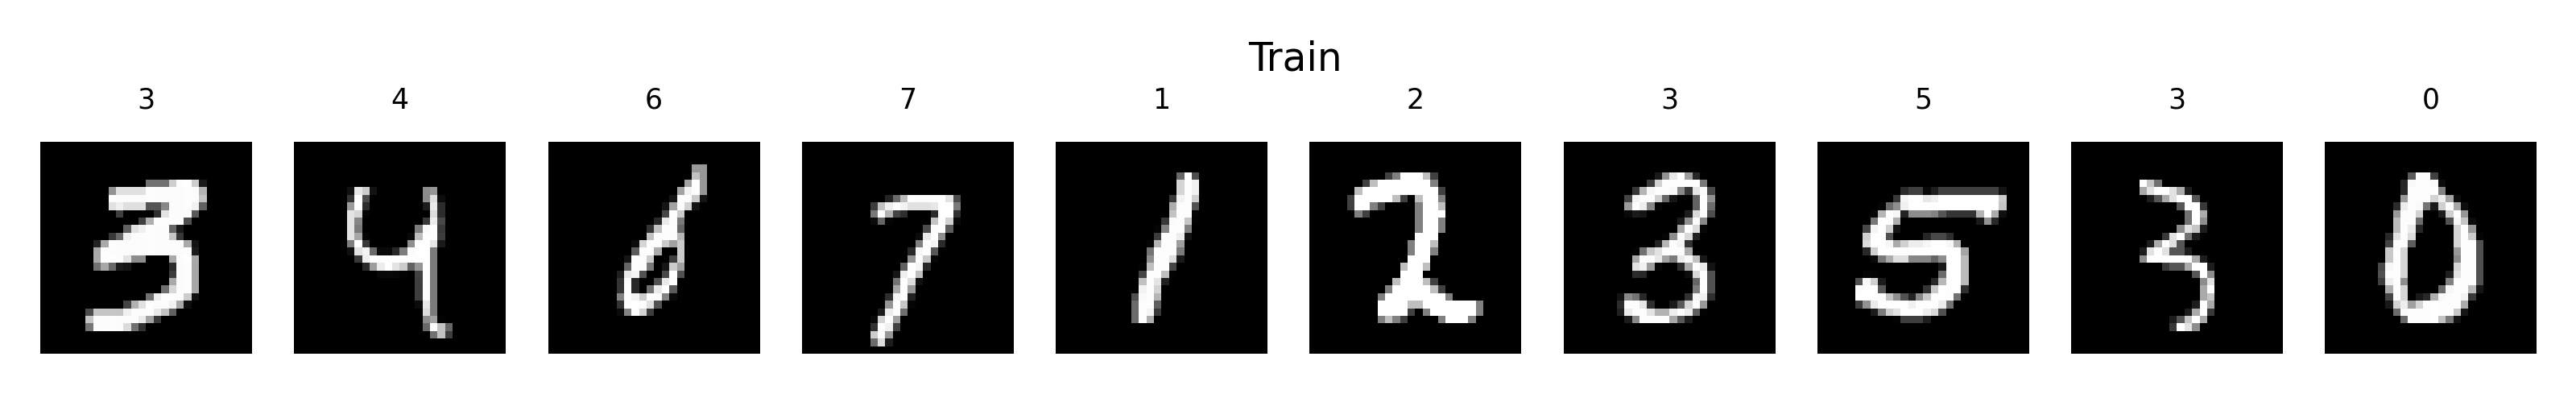

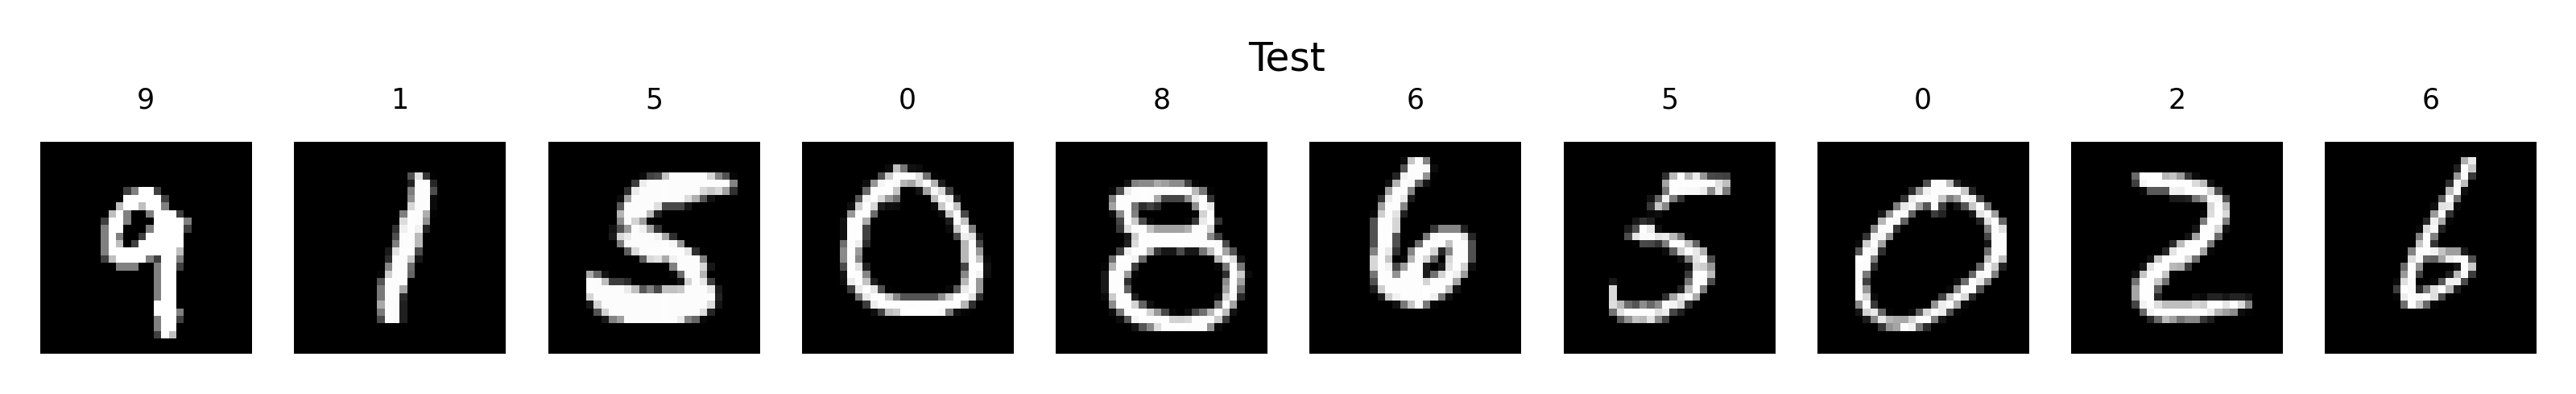

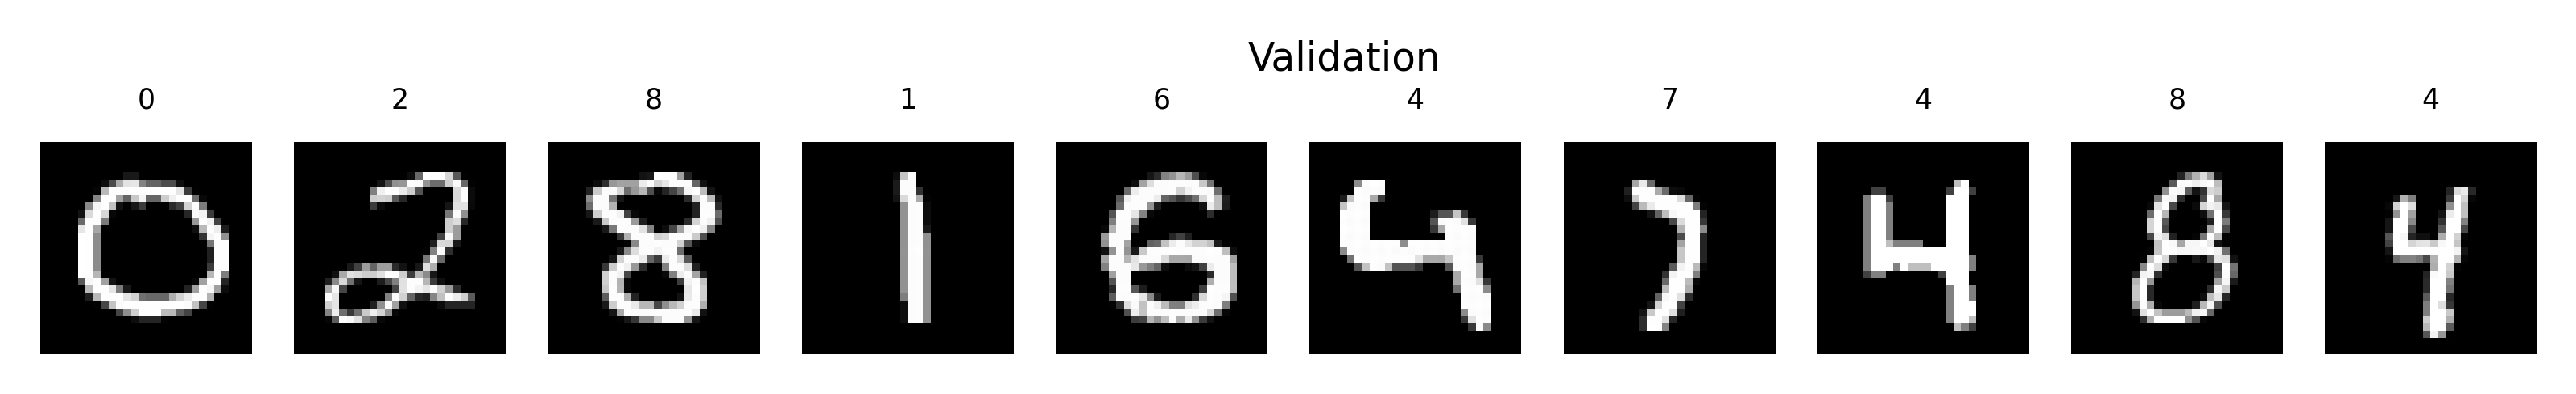

In [4]:
def show_images(split, title):
    fig = plt.figure(figsize=(8, 8), dpi=500)
    cols, rows = 10, 1

    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(split), size=(1,)).item()
        img, label = split[sample_idx]
        ax = fig.add_subplot(rows, cols, i)
        ax.axis("off")
        ax.imshow(img.permute(1, 2, 0), cmap="gray")
        ax.set_title(f"{label}", fontsize=5, )

    fig.text(0.5, y=0.55, s=title, fontsize=7)
    plt.show()


show_images(train_set, title='Train')
show_images(test_set,  title='Test')
show_images(val_set,  title='Validation')

In [19]:
class CNN(nn.Module):
    def __init__(self, l1=1000, l2=500) -> None:
        super(CNN, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(
            3, 3), stride=(1, 1), padding=(1, 1))

        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=l1)
        self.fc2 = nn.Linear(in_features=l1, out_features=l2)
        self.fc3 = nn.Linear(in_features=l2, out_features=10)

    def forward(self, x):
        # x = self.conv1_1(x)
        # x = self.relu(x)
        # x = self.pool(self.relu(self.conv1_2(self.relu(self.conv1_1(x)))))
        # x = self.pool(self.relu(self.conv2_2(self.relu(self.conv2_1(x)))))
        # x = self.pool(self.relu(self.conv3_2(self.relu(self.conv3_1(x)))))
        # x = self.droupout(self.relu(self.fc1(x.view(x.shape[0], -1))))
        # x = self.droupout(self.relu(self.fc2(x)))
        # x = self.fc3(x)


        x = self.conv1_1(x)
        x = self.relu(x)
        print(x.shape)

        x = self.conv1_2(x)
        x = self.relu(x)
        print(x.shape)

        x = self.pool(x)

        x = self.conv2_1(x)
        x = self.relu(x)
        print(x.shape)

        x = self.conv2_2(x)
        x = self.relu(x)
        print(x.shape)

        x = self.pool(x)

        x = self.conv3_1(x)
        x = self.relu(x)
        print(x.shape)

        x = self.conv3_2(x)
        x = self.relu(x)
        print(x.shape)

        x = self.pool(x)
        print(x.shape) 

        x = x.view(x.shape[0], -1)  # Flatten the tensor for the fully connected layer

        x = self.fc1(x)
        print(x.shape)

        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        print(x.shape)

        x = self.dropout(x)

        x = self.fc3(x)
        print(x.shape)


        return x

In [20]:
cnn = CNN(1024, 256)

In [21]:
cnn(train_set[0][0].unsqueeze(0))

torch.Size([1, 64, 28, 28])
torch.Size([1, 64, 28, 28])
torch.Size([1, 128, 14, 14])
torch.Size([1, 128, 14, 14])
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 3, 3])
torch.Size([1, 1024])
torch.Size([1, 256])
torch.Size([1, 10])


tensor([[ 0.0652,  0.0223,  0.0460,  0.0660,  0.0183, -0.0805,  0.0282,  0.0031,
          0.0033, -0.0110]], grad_fn=<AddmmBackward0>)

In [49]:
def train_model(config):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            cnn = nn.DataParallel(cnn)

    cnn = CNN(l1=int(config["l1"]), l2=int(config["l2"])).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=config["lr"])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            model_state, optimizer_state = torch.load(
                Path(checkpoint_dir) / "checkpoint.pt"
            )

            cnn.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    train_loader = DataLoader(train_set, batch_size=int(config["batch_size"]), drop_last=True, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=int(config["batch_size"]), shuffle=True)

    for epoch in range(50):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0

        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = cnn(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = Path(temp_checkpoint_dir) / "checkpoint.pt"
            torch.save(
                (cnn.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps, "accuracy": correct / total},
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [50]:
config = {
    "l1": tune.choice([1024, 512]),
    "l2": tune.choice([512, 256]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([16, 32, 64, 128])
}

In [51]:
gpus_per_trial = 0.0
num_samples = 1
max_num_epochs = 1

scheduler = ASHAScheduler(
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2,
)

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_model),
        resources={"cpu": 12, "gpu": gpus_per_trial}
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=num_samples
    ),
    param_space=config
)

result = tuner.fit()

2024-08-23 16:54:00,773	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/aniat/ray_results/train_model_2024-08-23_16-50-04' in 0.0166s.
2024-08-23 16:54:00,790	INFO tune.py:1041 -- Total run time: 236.55 seconds (236.25 seconds for the tuning loop).


In [7]:
def test_accuracy(net, device="cpu"):

    testloader = DataLoader(test_set, batch_size=64, shuffle=False)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [55]:
best_result = result.get_best_result("loss", "min")
print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["loss"]))
print("Best trial final validation accuracy: {}".format(best_result.metrics["accuracy"]))

Best trial config: {'l1': 1024, 'l2': 512, 'lr': 0.00031612448989960394, 'batch_size': 32}
Best trial final validation loss: 0.06696010374549466
Best trial final validation accuracy: 0.9813333333333333


In [72]:
best_trained_model = CNN(best_result.config['l1'], best_result.config['l2'])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)

best_trained_model.to(device)
checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")
model_state, optimizer_state = torch.load(checkpoint_path)
best_trained_model.load_state_dict(model_state)
torch.save(best_trained_model.state_dict(), "./train_model.pt")

In [8]:
best_trained_model = CNN(l1=1024, l2=256)
best_trained_model.load_state_dict(torch.load("./train_model.pt", map_location="cpu"))
best_trained_model.eval()

CNN(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (droupout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [21]:
test_acc = test_accuracy(best_trained_model, device)
test_acc

100%|██████████| 157/157 [00:12<00:00, 12.62it/s]


0.9927

In [9]:
testloader = DataLoader(test_set, batch_size=1, shuffle=True)
x = iter(testloader)
inp, label = next(x)

In [10]:
activations = {}
def get_activation(layer_name):
    def hook(module, input, output):
        activations[layer_name] = output.detach().squeeze(0)
    
    return hook

In [87]:
conv_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2']
best_trained_model.conv1_1.register_forward_hook(get_activation('conv1_1'))
best_trained_model.conv1_2.register_forward_hook(get_activation('conv1_2'))

best_trained_model.conv2_1.register_forward_hook(get_activation('conv2_1'))
best_trained_model.conv2_2.register_forward_hook(get_activation('conv2_2'))

best_trained_model.conv3_1.register_forward_hook(get_activation('conv3_1'))
best_trained_model.conv3_2.register_forward_hook(get_activation('conv3_2'))

In [91]:
out = best_trained_model(inp)

In [94]:
def convert_to_255(tensor):
    min_vals = tensor.min()
    max_vals = tensor.max()
    scaled = ((tensor - min_vals) / (max_vals - min_vals)) * 255
    scaled = scaled.round().clamp(0, 255)
    return scaled

for conv_layer in conv_layers:  
    print(activations[conv_layer].shape)

    for i in range(activations[conv_layer].shape[0]):
        activations[conv_layer][i] = convert_to_255(activations[conv_layer][i])
    
    activations[conv_layer] = activations[conv_layer].to(torch.uint8)

torch.Size([64, 28, 28])
torch.Size([64, 28, 28])
torch.Size([128, 14, 14])
torch.Size([128, 14, 14])
torch.Size([256, 7, 7])
torch.Size([256, 7, 7])


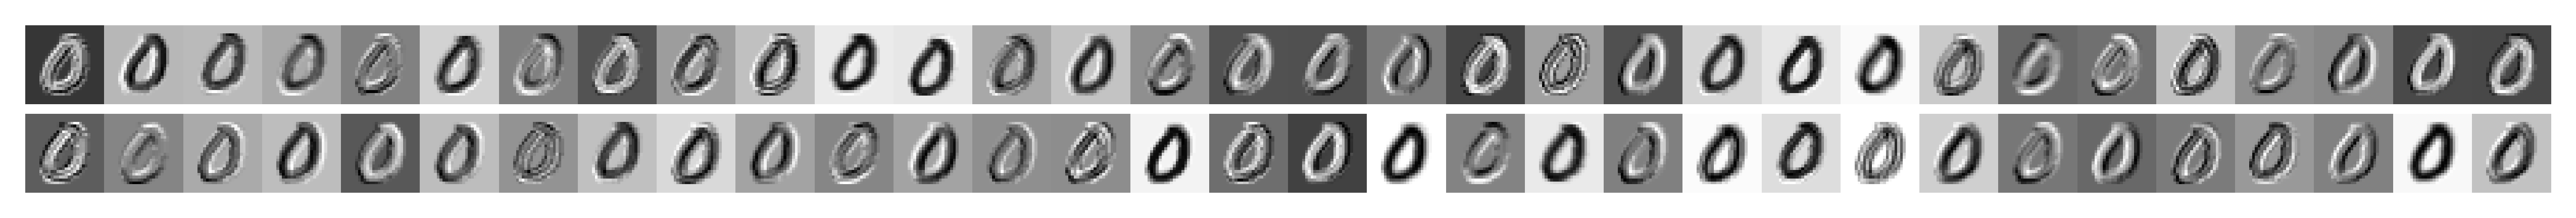

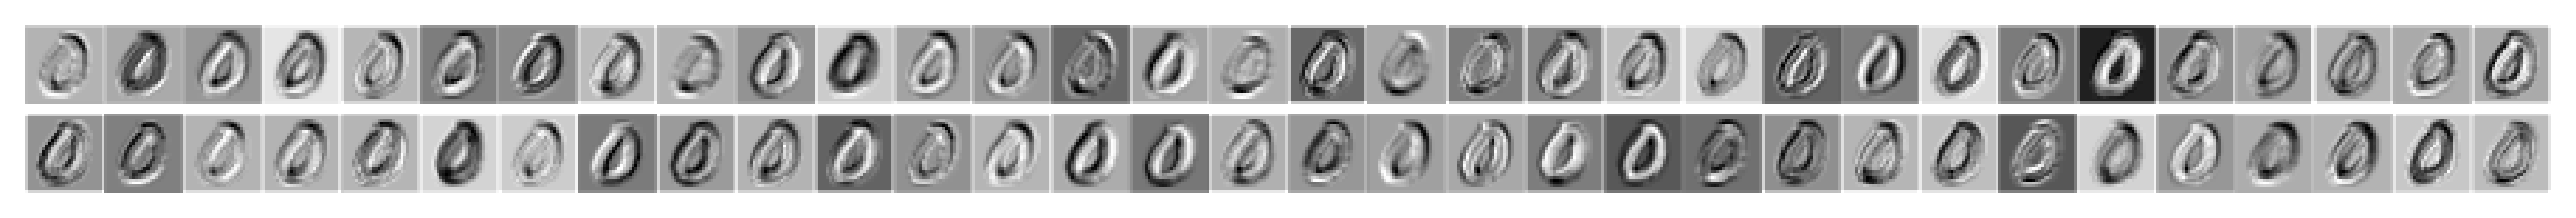

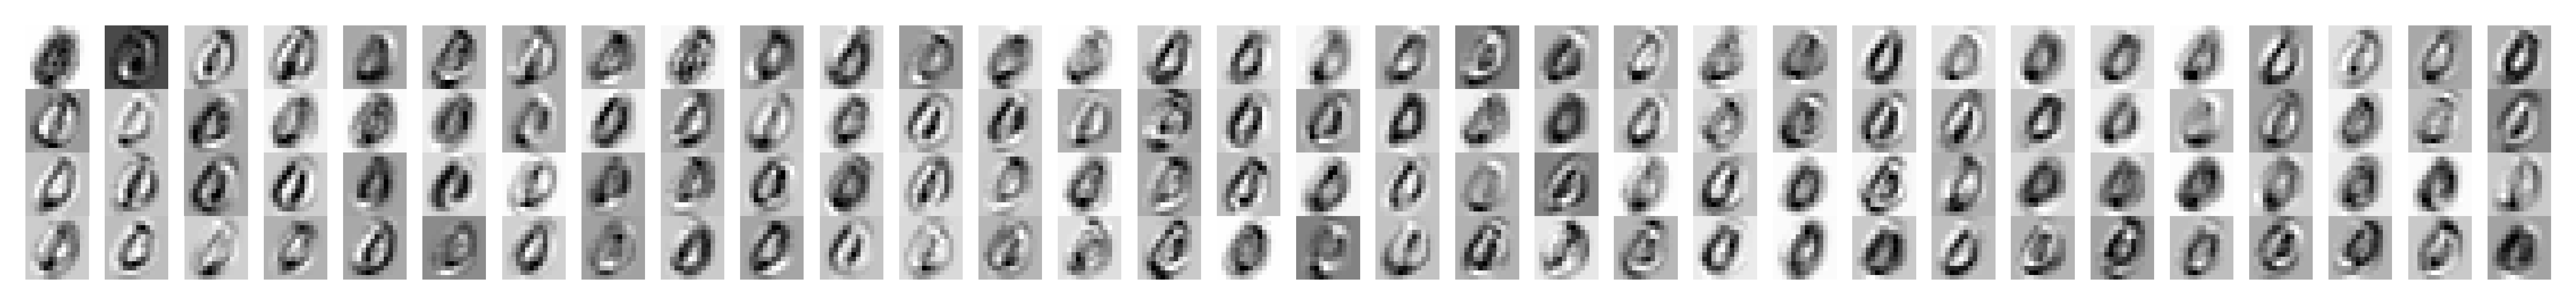

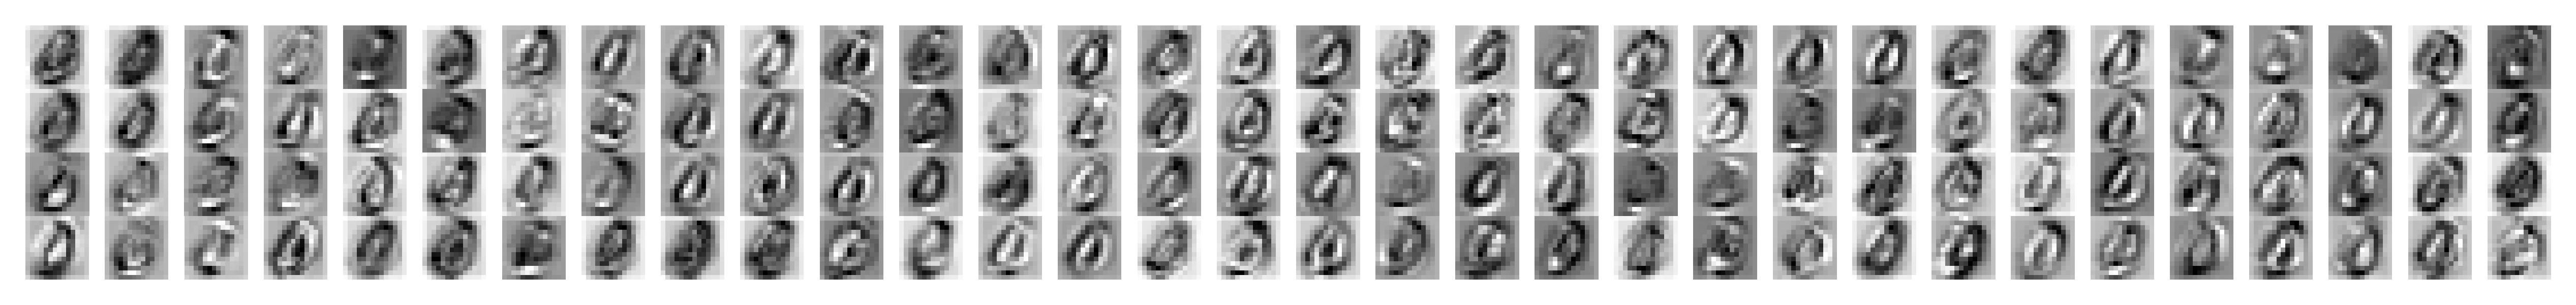

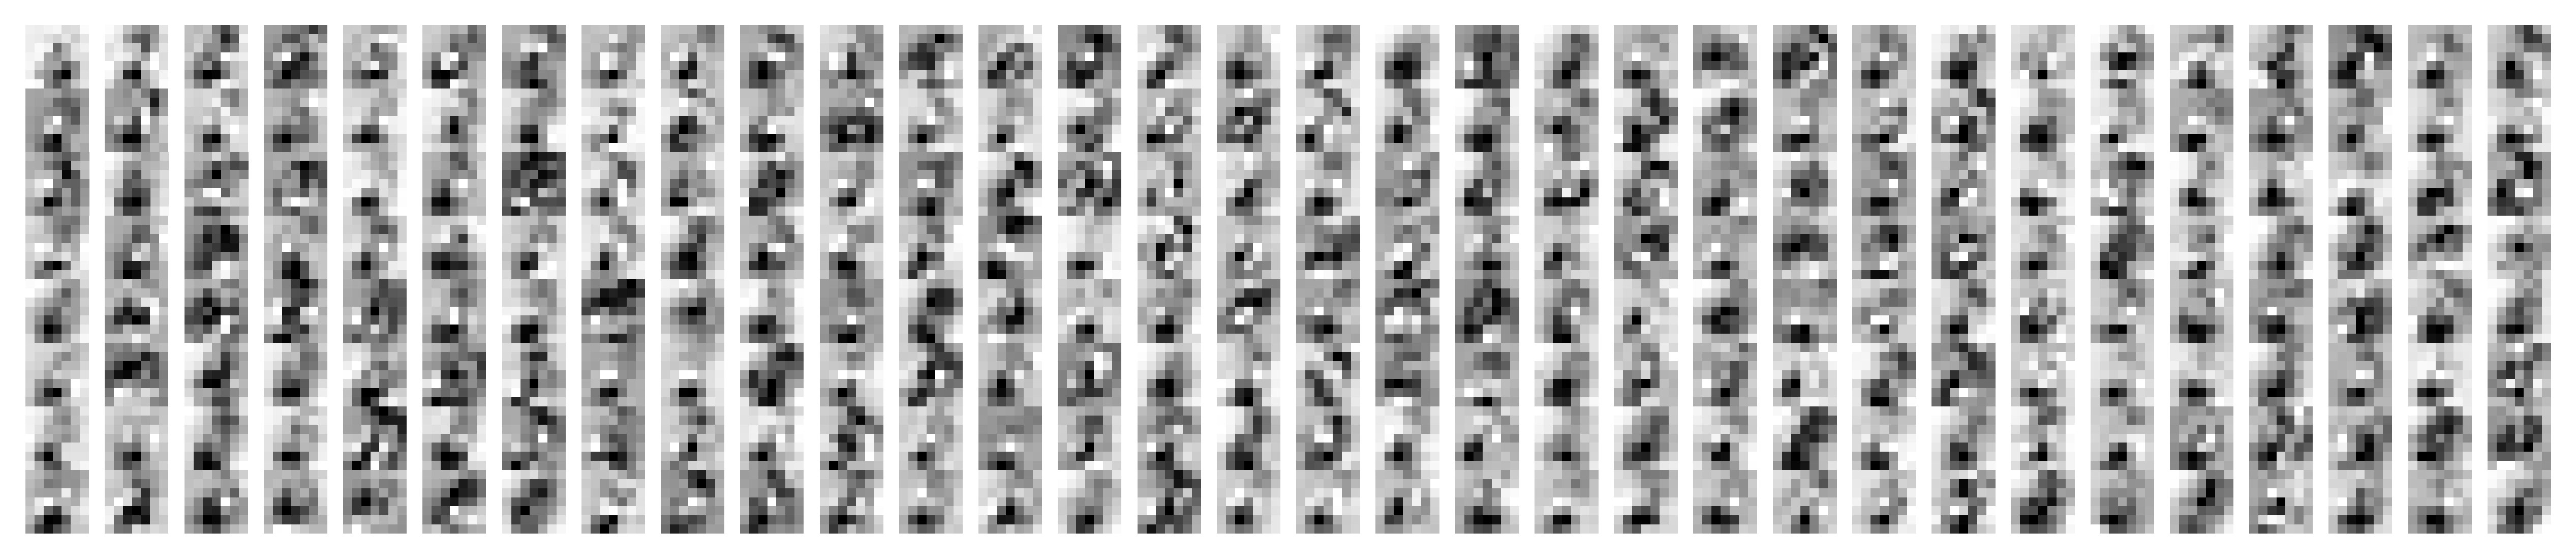

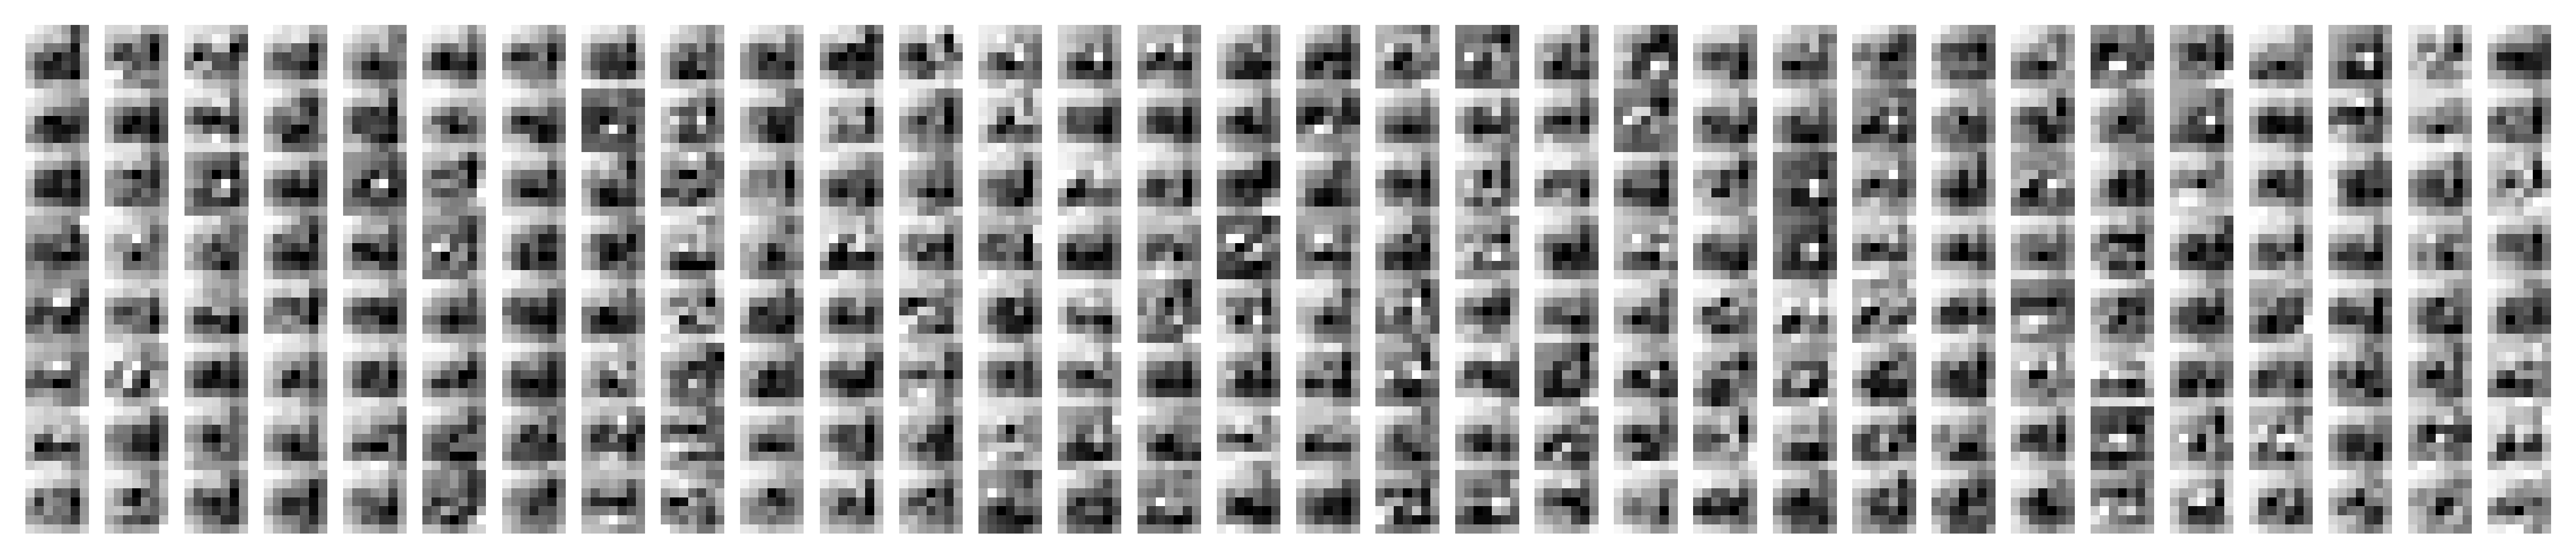

In [96]:
def plot_activations(activations, layer_name, rows, cols, top=0.1):
    fig = plt.figure(figsize=(10, 10), dpi=500)
    for i in range(1, cols * rows + 1):
        activation = activations[layer_name][i - 1]
        ax = fig.add_subplot(rows, cols, i)
        ax.axis("off")
        ax.imshow(activation, cmap="gray")

    plt.subplots_adjust(left=0, right=1, top=top, bottom=0, wspace=0, hspace=0)
    plt.show()


plot_activations(activations, 'conv1_1', 64 // 32, 32, 0.07)
plot_activations(activations, 'conv1_2', 64 // 32, 32, 0.07)

plot_activations(activations, 'conv2_1', 128 // 32, 32, 0.1)
plot_activations(activations, 'conv2_2', 128 // 32, 32, 0.1)

plot_activations(activations, 'conv3_1', 256 // 32, 32, 0.2)
plot_activations(activations, 'conv3_2', 256 // 32, 32, 0.2)